### Imports e bases

In [1]:
from tabpfn import TabPFNRegressor
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os
import time
from sklearn.model_selection import KFold
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
# df_mcar_50 = pd.read_parquet('/Users/izadoraganem/Imputation/Imputation/TabPfn/df_mcar_50.parquet')
# print(df_mcar_50.shape, df_mcar_50['sat_fio2'].isna().sum())

# original_base = pd.read_parquet('/Users/izadoraganem/Imputation/Imputation/TabPfn/Base_onda_Onda 1_desfecho_obito_variaveis_all.parquet')
# print(original_base.shape, original_base['sat_fio2'].isna().sum())

# idx = df_mcar_50[df_mcar_50['sat_fio2'].isna()].index
# df_nans = df_mcar_50.loc[idx]
# df_controle = original_base.loc[idx]

# print(df_controle.shape, df_controle['sat_fio2'].isna().sum())
# print(df_nans.shape, df_nans['sat_fio2'].isna().sum())

# df_nans.to_parquet('/Users/izadoraganem/Imputation/Imputation/TabPfn/df_nans.parquet')
# df_controle.to_parquet('/Users/izadoraganem/Imputation/Imputation/TabPfn/df_controle.parquet')
dir = '/Users/izadoraganem/Imputation/Imputation/TabPfn/Bases'
df_nans = pd.read_parquet(f'{dir}/df_nans.parquet')
df_controle = pd.read_parquet(f'{dir}/df_controle.parquet')


print(df_nans.shape, df_nans['sat_fio2'].isna().sum())
print(df_controle.shape, df_controle['sat_fio2'].isna().sum())

(3030, 62) 3030
(3030, 62) 0


### Kfold

In [ ]:

# kf = KFold(n_splits=10, shuffle=True, random_state=78)

# i = 0
# for train_idx, test_idx in kf.split(df_nans):
#     df_train = df_controle.iloc[train_idx]
#     df_test = df_nans.iloc[test_idx]
    
#     df_train.to_parquet(f"/home/izadoraganem/Imputation/TabPfn/Kfold/fold{i}_train.parquet", index=True)
#     df_test.to_parquet(f"/home/izadoraganem/Imputation/TabPfn/Kfold/fold{i}_test.parquet", index=True)
    
#     print(f"Fold {i} salvo: treino({len(df_train)}), teste({len(df_test)})")
    
    
#     i+=1


Fold 0 salvo: treino(2727), teste(303)
Fold 1 salvo: treino(2727), teste(303)
Fold 2 salvo: treino(2727), teste(303)
Fold 3 salvo: treino(2727), teste(303)
Fold 4 salvo: treino(2727), teste(303)
Fold 5 salvo: treino(2727), teste(303)
Fold 6 salvo: treino(2727), teste(303)
Fold 7 salvo: treino(2727), teste(303)
Fold 8 salvo: treino(2727), teste(303)
Fold 9 salvo: treino(2727), teste(303)


### Métodos de imputação

In [3]:
top10 = ["sat_fio2", "vm_adm_final", "po2_fio2_adm_final", "fr_adm_final", "obito", "Hospital_GDP", "plaquetas_adm_final", "fc_adm_final", "bicarbonato_adm_final", "ph_adm_final", "pcr_adm_final"]

def missforest(df_train, df_test):
    imputer = IterativeImputer(estimator=ExtraTreesRegressor(n_estimators=10, random_state=7), 
                               max_iter=20, random_state=7)
    imputer.fit(df_train)
    df_imputed = df_test.copy()
    df_imputed[:] = imputer.transform(df_test)
    return pd.DataFrame(df_imputed, columns=df_test.columns, index=df_test.index)

def MICE(df_train, df_test):
    imputer = IterativeImputer(estimator=BayesianRidge(), max_iter=20, random_state=7)
    imputer.fit(df_train)
    df_imputed = df_test.copy()
    df_imputed = imputer.transform(df_test)
    return pd.DataFrame(df_imputed, columns=df_test.columns, index=df_test.index)

def KNN(df_train, df_test):
    imputer = KNNImputer(n_neighbors=3)
    imputer.fit(df_train)
    df_imputed = df_test.copy()
    df_imputed = imputer.transform(df_test)
    return pd.DataFrame(df_imputed, columns=df_test.columns, index=df_test.index)

def KNN_otimizado(df_train, df_test):
    imputer = KNNImputer(n_neighbors=3)
    imputer.fit(df_train[top10])
    df_imputed = df_test.copy()
    df_imputed = imputer.transform(df_test[top10])
    return pd.DataFrame(df_imputed, columns=df_test[top10].columns, index=df_test.index)


def Mean(df_train, df_test):
    df_imputed = df_test.copy()
    mean = df_train['sat_fio2'].mean()
    df_imputed['sat_fio2'] = df_test['sat_fio2'].fillna(mean)
    return pd.DataFrame(df_imputed, columns=df_test.columns, index=df_test.index)


def tabpfn_imputer(df_train, df_test):
    df_imputed = df_test.copy()
    X_train_1 = df_train.drop(columns=["sat_fio2"])
    y_train = df_train["sat_fio2"]
    # regressor com cuda - roda em GPU
    reg = TabPFNRegressor(device="cuda")
    reg.fit(X_train_1.values, y_train.values)
    preds = reg.predict(df_test.drop(columns=["sat_fio2"]).values)
    df_imputed["sat_fio2"] = preds
    return pd.DataFrame(df_imputed, columns=df_test.columns, index=df_test.index)

In [16]:
def calculate_errors(df_true, df_imputed, column):
    df_subset = df_true.loc[df_imputed.index, :]
    mae = mean_absolute_error(df_subset[column], df_imputed[column])
    mse = mean_squared_error(df_subset[column], df_imputed[column])
    return mae, mse


imputadores = {'tabpfn': tabpfn_imputer, 'média': Mean,'knn': KNN, 'knn++': KNN_otimizado,'mice': MICE, 'missforest': missforest}
metricas = []

for i in range(10): 
    
    X_train = pd.read_parquet(f"/home/izadoraganem/Imputation/TabPfn/Kfold/fold{i}_train.parquet")
    X_test  = pd.read_parquet(f"/home/izadoraganem/Imputation/TabPfn/Kfold/fold{i}_test.parquet")


    for nome, func in imputadores.items():
        print(func, nome)
        start_time = time.time()
        print(X_train.shape, X_test.shape)
        # print(X_train['sat_fio2'].isna().sum(), X_test['sat_fio2'].isna().sum())
        df_imputed = func(X_train.copy(), X_test.copy())
        tempo = time.time() - start_time

        #salvar em uma pasta para o metodo cada df imputado
        os.makedirs(f"Results/{nome}", exist_ok=True)
        df_imputed.to_parquet(f"Results/{nome}/df_imputed_fold_{i}.parquet")

        mae, mse = calculate_errors(df_controle, df_imputed, 'sat_fio2')

        metricas.append({
            'fold': i,
            'metodo': nome,
            'mae': mae,
            'mse': mse,
            'tempo_segundos': tempo
        })

df_metricas = pd.DataFrame(metricas)
# df_metricas.to_csv('metricas_imputacao.csv', index=False)


<function tabpfn_imputer at 0x7fc1ca3dfa60> tabpfn
(2727, 62) (303, 62)


/home/izadoraganem/.pyenv/versions/3.12.7/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<function Mean at 0x7fc1ca3df2e0> média
(2727, 62) (303, 62)
<function KNN at 0x7fc1ca3ddf80> knn
(2727, 62) (303, 62)
<function KNN_otimizado at 0x7fc1ca3dcc20> knn++
(2727, 62) (303, 62)
<function MICE at 0x7fc1ca3dfba0> mice
(2727, 62) (303, 62)
<function missforest at 0x7fc1ca3dd9e0> missforest
(2727, 62) (303, 62)


/home/izadoraganem/.pyenv/versions/3.12.7/lib/python3.12/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


<function tabpfn_imputer at 0x7fc1ca3dfa60> tabpfn
(2727, 62) (303, 62)
<function Mean at 0x7fc1ca3df2e0> média
(2727, 62) (303, 62)
<function KNN at 0x7fc1ca3ddf80> knn
(2727, 62) (303, 62)
<function KNN_otimizado at 0x7fc1ca3dcc20> knn++
(2727, 62) (303, 62)
<function MICE at 0x7fc1ca3dfba0> mice
(2727, 62) (303, 62)
<function missforest at 0x7fc1ca3dd9e0> missforest
(2727, 62) (303, 62)


/home/izadoraganem/.pyenv/versions/3.12.7/lib/python3.12/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


<function tabpfn_imputer at 0x7fc1ca3dfa60> tabpfn
(2727, 62) (303, 62)
<function Mean at 0x7fc1ca3df2e0> média
(2727, 62) (303, 62)
<function KNN at 0x7fc1ca3ddf80> knn
(2727, 62) (303, 62)
<function KNN_otimizado at 0x7fc1ca3dcc20> knn++
(2727, 62) (303, 62)
<function MICE at 0x7fc1ca3dfba0> mice
(2727, 62) (303, 62)
<function missforest at 0x7fc1ca3dd9e0> missforest
(2727, 62) (303, 62)


/home/izadoraganem/.pyenv/versions/3.12.7/lib/python3.12/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


<function tabpfn_imputer at 0x7fc1ca3dfa60> tabpfn
(2727, 62) (303, 62)
<function Mean at 0x7fc1ca3df2e0> média
(2727, 62) (303, 62)
<function KNN at 0x7fc1ca3ddf80> knn
(2727, 62) (303, 62)
<function KNN_otimizado at 0x7fc1ca3dcc20> knn++
(2727, 62) (303, 62)
<function MICE at 0x7fc1ca3dfba0> mice
(2727, 62) (303, 62)
<function missforest at 0x7fc1ca3dd9e0> missforest
(2727, 62) (303, 62)


/home/izadoraganem/.pyenv/versions/3.12.7/lib/python3.12/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


<function tabpfn_imputer at 0x7fc1ca3dfa60> tabpfn
(2727, 62) (303, 62)
<function Mean at 0x7fc1ca3df2e0> média
(2727, 62) (303, 62)
<function KNN at 0x7fc1ca3ddf80> knn
(2727, 62) (303, 62)
<function KNN_otimizado at 0x7fc1ca3dcc20> knn++
(2727, 62) (303, 62)
<function MICE at 0x7fc1ca3dfba0> mice
(2727, 62) (303, 62)
<function missforest at 0x7fc1ca3dd9e0> missforest
(2727, 62) (303, 62)


/home/izadoraganem/.pyenv/versions/3.12.7/lib/python3.12/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


<function tabpfn_imputer at 0x7fc1ca3dfa60> tabpfn
(2727, 62) (303, 62)
<function Mean at 0x7fc1ca3df2e0> média
(2727, 62) (303, 62)
<function KNN at 0x7fc1ca3ddf80> knn
(2727, 62) (303, 62)
<function KNN_otimizado at 0x7fc1ca3dcc20> knn++
(2727, 62) (303, 62)
<function MICE at 0x7fc1ca3dfba0> mice
(2727, 62) (303, 62)
<function missforest at 0x7fc1ca3dd9e0> missforest
(2727, 62) (303, 62)


/home/izadoraganem/.pyenv/versions/3.12.7/lib/python3.12/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


<function tabpfn_imputer at 0x7fc1ca3dfa60> tabpfn
(2727, 62) (303, 62)
<function Mean at 0x7fc1ca3df2e0> média
(2727, 62) (303, 62)
<function KNN at 0x7fc1ca3ddf80> knn
(2727, 62) (303, 62)
<function KNN_otimizado at 0x7fc1ca3dcc20> knn++
(2727, 62) (303, 62)
<function MICE at 0x7fc1ca3dfba0> mice
(2727, 62) (303, 62)
<function missforest at 0x7fc1ca3dd9e0> missforest
(2727, 62) (303, 62)


/home/izadoraganem/.pyenv/versions/3.12.7/lib/python3.12/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


<function tabpfn_imputer at 0x7fc1ca3dfa60> tabpfn
(2727, 62) (303, 62)
<function Mean at 0x7fc1ca3df2e0> média
(2727, 62) (303, 62)
<function KNN at 0x7fc1ca3ddf80> knn
(2727, 62) (303, 62)
<function KNN_otimizado at 0x7fc1ca3dcc20> knn++
(2727, 62) (303, 62)
<function MICE at 0x7fc1ca3dfba0> mice
(2727, 62) (303, 62)
<function missforest at 0x7fc1ca3dd9e0> missforest
(2727, 62) (303, 62)


/home/izadoraganem/.pyenv/versions/3.12.7/lib/python3.12/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


<function tabpfn_imputer at 0x7fc1ca3dfa60> tabpfn
(2727, 62) (303, 62)
<function Mean at 0x7fc1ca3df2e0> média
(2727, 62) (303, 62)
<function KNN at 0x7fc1ca3ddf80> knn
(2727, 62) (303, 62)
<function KNN_otimizado at 0x7fc1ca3dcc20> knn++
(2727, 62) (303, 62)
<function MICE at 0x7fc1ca3dfba0> mice
(2727, 62) (303, 62)
<function missforest at 0x7fc1ca3dd9e0> missforest
(2727, 62) (303, 62)


/home/izadoraganem/.pyenv/versions/3.12.7/lib/python3.12/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


<function tabpfn_imputer at 0x7fc1ca3dfa60> tabpfn
(2727, 62) (303, 62)
<function Mean at 0x7fc1ca3df2e0> média
(2727, 62) (303, 62)
<function KNN at 0x7fc1ca3ddf80> knn
(2727, 62) (303, 62)
<function KNN_otimizado at 0x7fc1ca3dcc20> knn++
(2727, 62) (303, 62)
<function MICE at 0x7fc1ca3dfba0> mice
(2727, 62) (303, 62)
<function missforest at 0x7fc1ca3dd9e0> missforest
(2727, 62) (303, 62)


/home/izadoraganem/.pyenv/versions/3.12.7/lib/python3.12/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [4]:
# results_final tem o valor de saturação imputado de cada paciente pelos diferentes métodos

imputadores = {'tabpfn': tabpfn_imputer, 'média': Mean,'knn': KNN, 'knn++': KNN_otimizado,'mice': MICE, 'missforest': missforest}


dfs = {nome: [] for nome in imputadores.keys()}

for i in range(10):
    for nome, func in imputadores.items():
        fold = pd.read_parquet(f'/Users/izadoraganem/Imputation/Imputation/TabPfn/Results/{nome}/df_imputed_fold_{i}.parquet')
        dfs[nome].append(fold[["sat_fio2"]])

for nome in dfs.keys():
    dfs[nome] = pd.concat(dfs[nome], axis=0)

results_final = pd.concat(dfs, axis=1)
results_final.columns = results_final.columns.droplevel(1)  

print(results_final)
print(results_final.shape)


           tabpfn       média         knn       knn++        mice  missforest
index                                                                        
10     370.304382  370.271570  406.746032  397.619048  370.199548  445.714286
19     238.381500  370.271570  288.638889  188.777778  268.706200  299.275794
22     251.311066  370.271570  420.634921  376.120448  329.530398  247.920554
36     458.284119  370.271570  453.968254  437.698413  419.558951  458.571429
41     344.033630  370.271570  382.936508  397.619048  373.558507  369.305556
...           ...         ...         ...         ...         ...         ...
7645   121.367996  371.251674  343.404762  418.849206  266.158397  108.883772
7659   330.920593  371.251674  289.539683  425.000000  431.727935  379.255952
7661   378.627747  371.251674  392.063492  440.873016  475.810366  361.755952
7672   371.285706  371.251674  389.384921  356.349206  399.260986  391.428571
7686   381.472595  371.251674  453.968254  403.968254  349.88582

### Lógica de quadrantes

In [5]:
top10 = ["vm_adm_final", "po2_fio2_adm_final", "fr_adm_final", "obito", "Hospital_GDP","plaquetas_adm_final", "fc_adm_final", "bicarbonato_adm_final", "ph_adm_final", "pcr_adm_final"]



df = df_controle.copy()

# imputa as outras features, pq a funcao nerarestneighboors nao aceita nan na entrada
imputer = KNNImputer(n_neighbors=3)
df_notNan = pd.DataFrame(imputer.fit_transform(df), columns=df.columns, index=df.index)


df_select = df_notNan[top10].copy()

scaler = MinMaxScaler()
df_select[top10] = scaler.fit_transform(df_select[top10])

k = 4  

nbrs = NearestNeighbors(n_neighbors=k, metric="manhattan") 
nbrs.fit(df_select)  

distances, indices = nbrs.kneighbors(df_select)  

distancia_media_dict = {index: distances[i, 1:].mean() for i, index in enumerate(df_select.index) if index in results_final.index}   

results_final["Distancia Media"] = results_final.index.map(distancia_media_dict)

entropia_media_dict = {}

for i, index in enumerate(df_select.index):
    if index in results_final.index:
        vizinhos_indices = indices[i, 1:] 

        vizinhos_valores = df_select.iloc[vizinhos_indices].values.flatten()

        kde = gaussian_kde(vizinhos_valores)
        pdf_values = kde(vizinhos_valores)

        entropy = -np.sum(pdf_values * np.log(pdf_values + 1e-10)) / len(vizinhos_valores)


        entropia_media_dict[index] = entropy

results_final["Entropia"] = results_final.index.map(entropia_media_dict)


In [6]:
results_final["Erro Absoluto knn++"] = abs(results_final['knn++'] - df_controle['sat_fio2'])


In [7]:
results_final

,tabpfn,média,knn,knn++,mice,missforest,Distancia Media,Entropia,Erro Absoluto knn++
index,,,,,,,,,
10,370.304382,370.271570,406.746032,397.619048,370.199548,445.714286,0.118212,-0.253189,54.761905
19,238.381500,370.271570,288.638889,188.777778,268.706200,299.275794,0.168377,-0.261863,83.444444
22,251.311066,370.271570,420.634921,376.120448,329.530398,247.920554,0.481597,0.107836,51.120448
36,458.284119,370.271570,453.968254,437.698413,419.558951,458.571429,0.147988,-0.202490,94.841270
41,344.033630,370.271570,382.936508,397.619048,373.558507,369.305556,0.510312,-0.010423,97.619048
...,...,...,...,...,...,...,...,...,...
7645,121.367996,371.251674,343.404762,418.849206,266.158397,108.883772,0.551342,0.025275,328.322891
7659,330.920593,371.251674,289.539683,425.000000,431.727935,379.255952,0.303910,0.016381,310.000000
7661,378.627747,371.251674,392.063492,440.873016,475.810366,361.755952,0.404198,0.003801,210.873016


In [10]:
media_x = results_final["Distancia Media"].mean()
media_y = results_final["Entropia"].mean()

results_final["quadrante"] = np.where(results_final["Distancia Media"] >= media_x, "Direita", "Esquerda")
results_final["quadrante"] += np.where(results_final["Entropia"] >= media_y, " Superior", " Inferior")



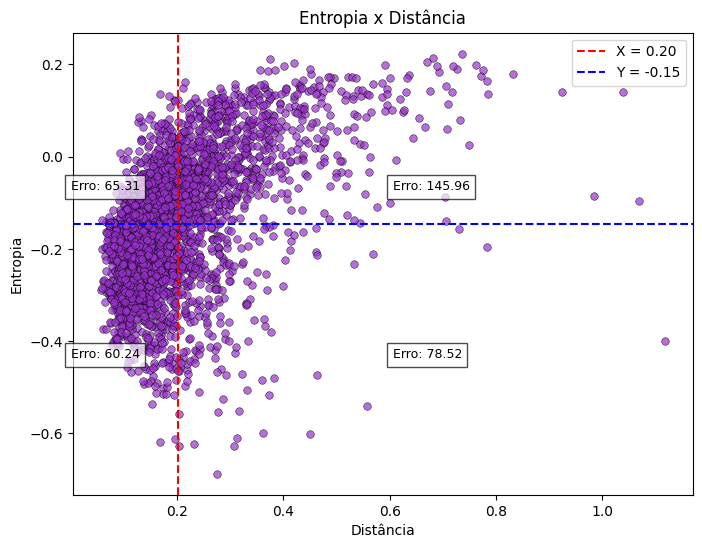

In [11]:
erro_medio = results_final.groupby("quadrante")["Erro Absoluto knn++"].mean()

plt.figure(figsize=(8,6))
sns.scatterplot(data=results_final, x="Distancia Media", y="Entropia", alpha=0.7, color="darkorchid", edgecolor = "black", s=30)

plt.axvline(media_x, color="red", linestyle="--", linewidth=1.5, label=f"X = {media_x:.2f}")
plt.axhline(media_y, color="blue", linestyle="--", linewidth=1.5, label=f"Y = {media_y:.2f}")

quadrantes_posicoes = {
    "Esquerda Inferior": (media_x * -0.0, media_y * 3),
    "Esquerda Superior": (media_x * -0.0, media_y * 0.5),
    "Direita Inferior": (media_x * 3, media_y * 3),
    "Direita Superior": (media_x * 3, media_y * 0.5)
}

for quad, pos in quadrantes_posicoes.items():
    plt.text(pos[0], pos[1], f"Erro: {erro_medio.get(quad, 0):.2f}", 
             fontsize=9, bbox=dict(facecolor='white', alpha=0.7))

plt.xlabel("Distância")
plt.ylabel("Entropia")
plt.title("Entropia x Distância")
plt.legend()

plt.show()

In [32]:
mae_quadrantes = results_final[['tabpfn', 'média', 'knn', 'knn++', 'mice', 'missforest']].copy()

mae_quadrantes = abs(mae_quadrantes.sub(df_controle['sat_fio2'], axis=0))

mae_quadrantes['quadrante'] = results_final['quadrante']

mae_quadrantes = mae_quadrantes.groupby('quadrante').mean()

mae_quadrantes.mean()



tabpfn        42.685585
média         96.018975
knn           91.127325
knn++         87.507932
mice          70.213559
missforest    53.563933
dtype: float64